# Análisis de resultados de Pron vs. Prompt

En este cuaderno analizamos los datos del experimento Pron vs. Prompt. Principalmente, haremos un análisis descriptivo y de correlaciones. Dejamos el modelo de efectos mixtos para R.

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import copy
import numpy as np
import matplotlib

# Configurar la fuente de toda la figura en Times New Roman
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
'''
matplotlib.rcParams['font.size'] = 14  # Ajustar el tamaño de la fuente
matplotlib.rcParams['axes.titlesize'] = 16
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
'''

"\nmatplotlib.rcParams['font.size'] = 14  # Ajustar el tamaño de la fuente\nmatplotlib.rcParams['axes.titlesize'] = 16\nmatplotlib.rcParams['axes.labelsize'] = 14\nmatplotlib.rcParams['xtick.labelsize'] = 12\nmatplotlib.rcParams['ytick.labelsize'] = 12\nmatplotlib.rcParams['legend.fontsize'] = 12\n"

Unas variables auxiliares que nos permitirán seleccionar subconjuntos de los datos.

In [46]:
columns_study = ['1_atractivo_titulo',
       '1_atractivo_estilo', '1_atractivo_tema', '2_originalidad_titulo',
       '2_originalidad_estilo', '2_originalidad_tema', '3_relevancia',
       '4_creatividad_titulo', '4_creatividad_sinopsis',
       '5_autoria_titulo', '5_autoria_sinopsis',
       '6_antologia', '6_opinion_lectores',
       '6_opinion_criticos', '6_voz_propia',]
columns_numeric_title = ['1_atractivo_titulo', 
       '2_originalidad_titulo', 
       '4_creatividad_titulo',]
columns_numeric_synopsis = ['1_atractivo_estilo', '1_atractivo_tema',
        '2_originalidad_estilo', '2_originalidad_tema',
       '4_creatividad_sinopsis', ]
       # '6_antologia', '6_opinion_lectores', '6_opinion_criticos', '6_voz_propia']
columns_numeric_synopsis_without6 = ['1_atractivo_estilo', '1_atractivo_tema',
        '2_originalidad_estilo', '2_originalidad_tema',
       '4_creatividad_sinopsis',]

#### Preparación de los DataFrames

Vamos a generar unas ids para las distintas operaciones sobre los datos.
- ``id_item``: nos permite identificar de manera unívoca la sinopsis que ha escrito un agente, pero no distingue entre evaluadores.
- ``id_user``: nos permite identificar cada sinopsis votada por cada crítico. No distingue entre escritores, esto nos permite hacer merge con los datos de Patricio, por un lado, y de GPT por otro.

In [47]:
df = pd.read_csv('data/resultados_en_bruto.csv')
df['id_title_sinopsis_writer'] = df['title_id'] + '_' + df['sinopsis_writer']
df['id_title_title_writer'] = df['title_id'] + '_' + df['title_writer']
df['id_title_user'] = df['title_id'] + '_' + df['username'] 
df.columns

Index(['Unnamed: 0', 'timestamp', 'username', '1_atractivo_titulo',
       '1_atractivo_estilo', '1_atractivo_tema', '2_originalidad_titulo',
       '2_originalidad_estilo', '2_originalidad_tema', '3_relevancia',
       '4_creatividad_titulo', '4_creatividad_sinopsis',
       '4_creatividad_comentario', '5_autoria_titulo', '5_autoria_sinopsis',
       '5_autoria_comentario', '6_antologia', '6_opinion_lectores',
       '6_opinion_criticos', '6_voz_propia', '6_comentario', 'title',
       'title_id', 'sinopsis_writer', 'title_writer', 'experiment',
       'id_title_sinopsis_writer', 'id_title_title_writer', 'id_for_es_en',
       'id_title_user'],
      dtype='object')

Ahora creamos los DataFrame para estudiar, separados por escritor de cada sinopsis, que es el objetivo principal de nuestro experimento. Esa diferencia.

In [48]:
def select_df_by(df, selector = 'sinopsis'):
    df = copy.copy(df)
    df[columns_numeric_synopsis] += 1
    mode = f'{selector}_writer'

    if selector == 'sinopsis':
        df = df.drop(columns=columns_numeric_title).reset_index(drop=True)
        df_gpt_en = df[df[mode] == 'gpt4_en'].reset_index(drop=True)
        df_gpt_es = df[df[mode] == 'gpt4_es'].reset_index(drop=True)
        join_id = 'id_title_user'

    else:
        df = df.drop(columns=columns_numeric_synopsis).reset_index(drop=True)
        df_gpt_en = df[df[mode] == 'machine'].reset_index(drop=True)
        df_gpt_es = df_gpt_en
        join_id = 'id_title_user'

    df_es = df[df.experiment=='SPANISH']
    df_en = df[df.experiment=='ENGLISH']

    df_patricio = df[df[mode] == 'patricio'].reset_index(drop=True)
    df_patricio_es = df_es[df_es[mode] == 'patricio']
    df_patricio_en = df_en[df_en[mode] == 'patricio']
    df_patricio_gpt_es = df_patricio_es.merge(df_gpt_es, on=join_id, suffixes=('_patricio', '_gpt4')).transpose().sort_index().transpose()
    df_patricio_gpt_en = df_patricio_en.merge(df_gpt_en, on=join_id, suffixes=('_patricio', '_gpt4')).transpose().sort_index().transpose()
    df_patricio_es_patricio_en = df_patricio_en.merge(df_patricio_es, on='title_id', suffixes=('_patricio_en', '_patricio_es')).transpose().sort_index().transpose()
    
    df_gpt_es_gpt_en = df_gpt_es.merge(df_gpt_en, on=join_id, suffixes=('_patricio', '_gpt4')).transpose().sort_index().transpose()

    df_gpt_en.to_csv('data/df_gpt_en.csv')
    df_gpt_es.to_csv('data/df_gpt_es.csv')
    df_patricio.to_csv('data/df_patricio.csv')
    df_patricio_gpt_es.to_csv('data/df_patricio_gpt_es.csv')
    df_patricio_gpt_en.to_csv('data/df_patricio_gpt_en.csv')
    df_patricio_es_patricio_en.to_csv('data/df_patricio_es_patricio_en.csv')
    df_gpt_es_gpt_en.to_csv('data/df_gpt_es_gpt_en.csv')

    return {'df_gpt_en':df_gpt_en,
            'df_gpt_es':df_gpt_es,
            'df_patricio':df_patricio,
            'df_patricio_gpt_es':df_patricio_gpt_es,
            'df_patricio_gpt_en':df_patricio_gpt_en,
            'df_patricio_es_patricio_en':df_patricio_es_patricio_en,
            'df_gpt_es_gpt_en':df_gpt_es_gpt_en}

In [49]:
dfs_title = select_df_by(df, 'title')

In [50]:
dfs_sinopsis = select_df_by(df, 'sinopsis')


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from scipy.stats import gaussian_kde

# Crear un dataframe similar a 'both' con columnas 'EmployeeType', 'team_work', 'tools_needed' con datos discretos tipo likert
np.random.seed(0)

def plot_scatter_with_dynamic_jitter(df, key_x, key_y, group_x_y, legend):
    df = copy.deepcopy(df)

    # Calcular la densidad de puntos
    xy = np.vstack([df[key_x], df[key_y]])
    z = gaussian_kde(xy)(xy)
    df['density'] = z

    # Normalizar la densidad para ajustar el jitter
    norm_density = (df['density'] - df['density'].min()) / (df['density'].max() - df['density'].min())
    jitter_strength = norm_density * 0.3  # Ajustar la fuerza del jitter

    # Añadir jitter basado en la densidad
    df[key_x] = df[key_x] + np.random.uniform(-jitter_strength, jitter_strength, df.shape[0])
    df[key_y] = df[key_y] + np.random.uniform(-jitter_strength, jitter_strength, df.shape[0])

    # Crear el scatter plot con jitter dinámico
    plt.figure(figsize=(8, 5))
    scatter_plot = sns.scatterplot(data=df, 
                    x=key_x, 
                    y=key_y, 
                    #hue=group_x_y, 
                    #size='density', 
                    #palette='viridis', 
                    markers=["o", "s"],  # Cambiar los marcadores
                    alpha=0.7, 
                    edgecolor='black', 
                    linewidth=0.5)
    
    plt.xlabel(key_x, fontsize=14)
    plt.ylabel(key_y, fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_aspect('equal', adjustable='box')

    # Ajustar los límites de los ejes
    plt.xlim(-0.5, 3.5)
    plt.ylim(-0.5, 3.5)
    plt.xticks(range(0, 4), fontsize=12)
    plt.yticks(range(0, 4), fontsize=12)
    if legend:
        plt.legend(title='Writer', title_fontsize='12', fontsize='10', loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
    
    plt.margins(x=0, y=0)
    plt.tight_layout(pad=0.5)
    plt.savefig(f'{key_x}_{key_y}_dynamic_jitter.pdf', bbox_inches='tight', pad_inches=0.1)
    plt.show()


In [52]:
new_df = pd.DataFrame()
new_df['Attractive'] = df['1_atractivo_estilo'].tolist() + df['1_atractivo_tema'].to_list()
new_df['Originality'] = df['2_originalidad_estilo'].tolist() + df['2_originalidad_tema'].to_list()
new_df['Creativity'] = df['4_creatividad_sinopsis'].tolist() + df['4_creatividad_sinopsis'].to_list()
new_df['sinopsis_writer'] = df['sinopsis_writer'].tolist() + df['sinopsis_writer'].tolist()
map_writer = {'gpt4_es' : 'GPT4 in Spanish', 'gpt4_en':'GPT4 in English', 'patricio':'Professional Writer'}
new_df['sinopsis_writer'] = new_df['sinopsis_writer'].apply(lambda x: map_writer[x])
new_df

,Attractive,Originality,Creativity,sinopsis_writer
0,2,2,1,GPT4 in English
1,0,0,0,GPT4 in English
2,0,0,0,GPT4 in English
3,0,0,1,GPT4 in English
4,0,0,0,GPT4 in English
...,...,...,...,...
1435,1,2,3,Professional Writer
1436,2,3,3,Professional Writer
1437,2,2,2,Professional Writer
1438,2,1,1,Professional Writer


In [53]:
print(new_df[['Attractive','Originality','Creativity']].corr(method='spearman').to_latex())

\begin{tabular}{lrrr}
\toprule
 & Attractive & Originality & Creativity \\
\midrule
Attractive & 1.000000 & 0.778496 & 0.717594 \\
Originality & 0.778496 & 1.000000 & 0.729353 \\
Creativity & 0.717594 & 0.729353 & 1.000000 \\
\bottomrule
\end{tabular}



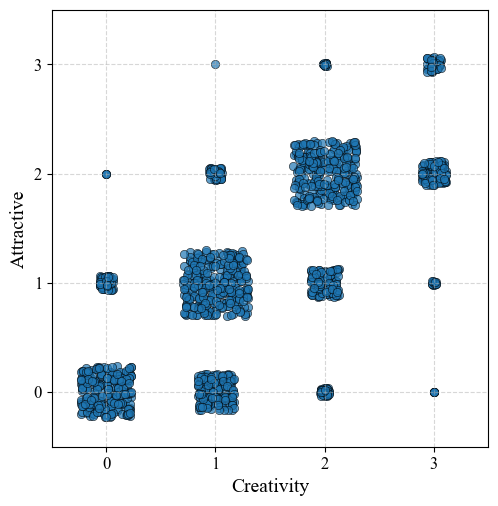

In [54]:
plot_scatter_with_dynamic_jitter(new_df, 'Creativity', 'Attractive', 'sinopsis_writer', legend=False)

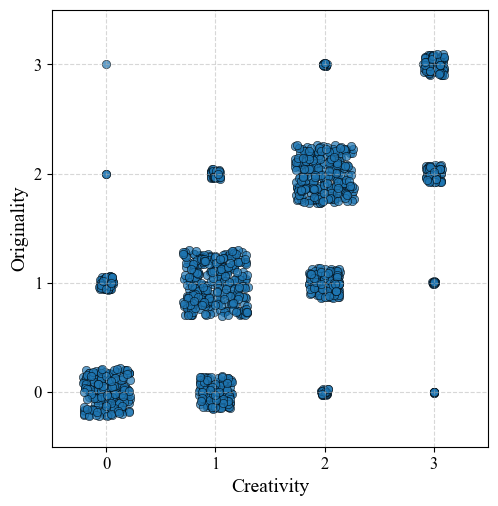

In [55]:
plot_scatter_with_dynamic_jitter(new_df, 'Creativity', 'Originality', 'sinopsis_writer', legend=False)

In [56]:
# Llamar a la función con el dataframe y las columnas correspondientes
plot_scatter_with_dynamic_jitter(df, '4_creatividad_sinopsis', '1_atractivo_estilo', 'sinopsis_writer')
plot_scatter_with_dynamic_jitter(df, '4_creatividad_sinopsis', '1_atractivo_tema', 'sinopsis_writer')
plot_scatter_with_dynamic_jitter(df, '4_creatividad_sinopsis', '2_originalidad_estilo', 'sinopsis_writer')
plot_scatter_with_dynamic_jitter(df, '4_creatividad_sinopsis', '2_originalidad_tema', 'sinopsis_writer')

TypeError: plot_scatter_with_dynamic_jitter() missing 1 required positional argument: 'legend'

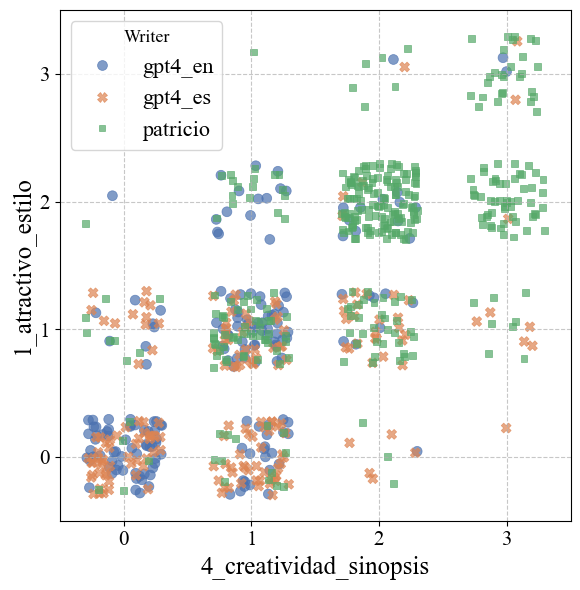

In [ ]:
plot_scatter(df,  '4_creatividad_sinopsis', '1_atractivo_estilo','sinopsis_writer')

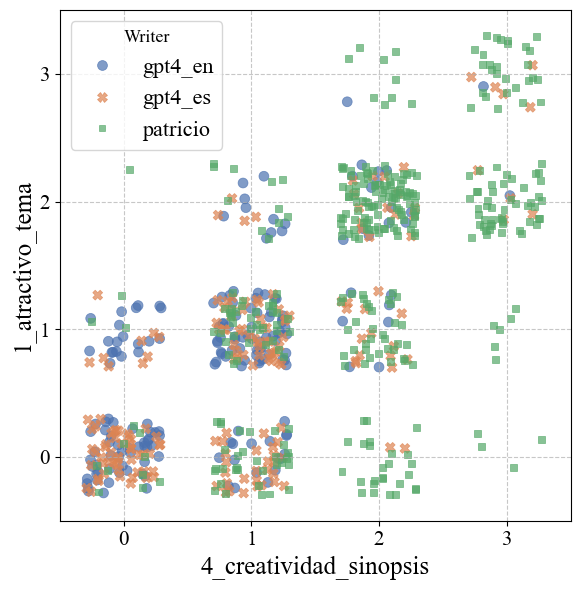

In [ ]:
plot_scatter(df,  '4_creatividad_sinopsis', '1_atractivo_tema','sinopsis_writer')

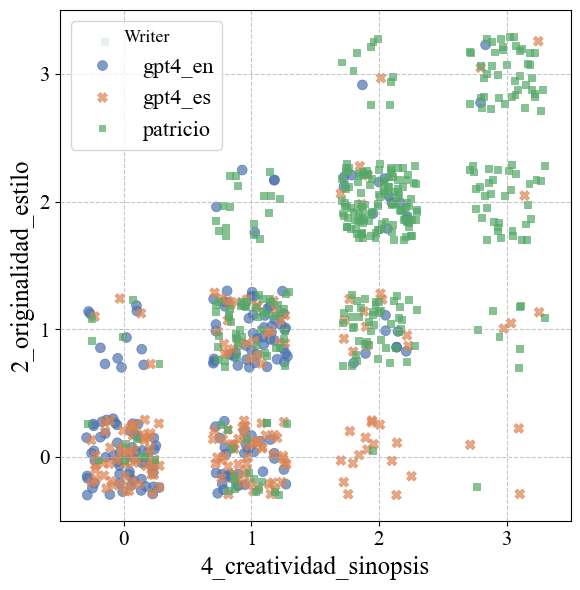

In [ ]:
plot_scatter(df,  '4_creatividad_sinopsis', '2_originalidad_estilo','sinopsis_writer')

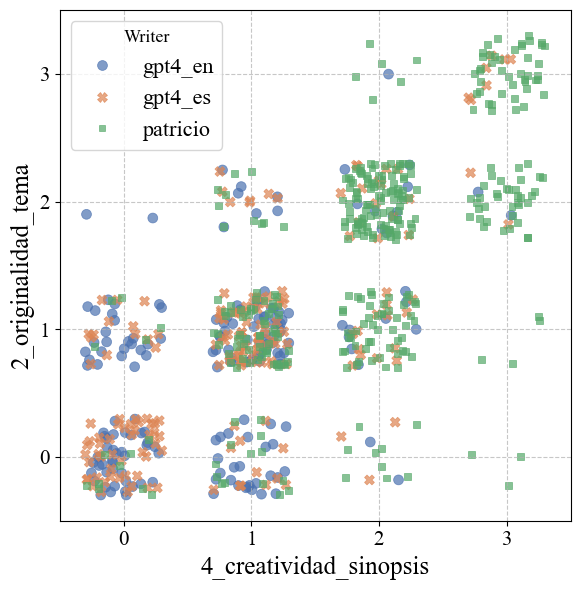

In [ ]:
plot_scatter(df,  '4_creatividad_sinopsis', '2_originalidad_tema','sinopsis_writer')

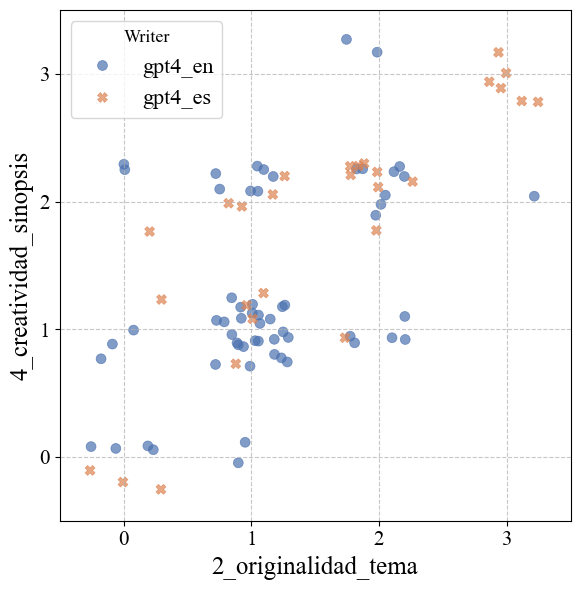

In [ ]:
df_work = df[(df['5_autoria_sinopsis'] == 'Un escritor consagrado.') | (df['5_autoria_sinopsis'] == 'Un escritor novel.')]
df_work = df_work[df_work['sinopsis_writer'] != 'patricio']
plot_scatter(df_work, '2_originalidad_tema', '4_creatividad_sinopsis', 'sinopsis_writer')

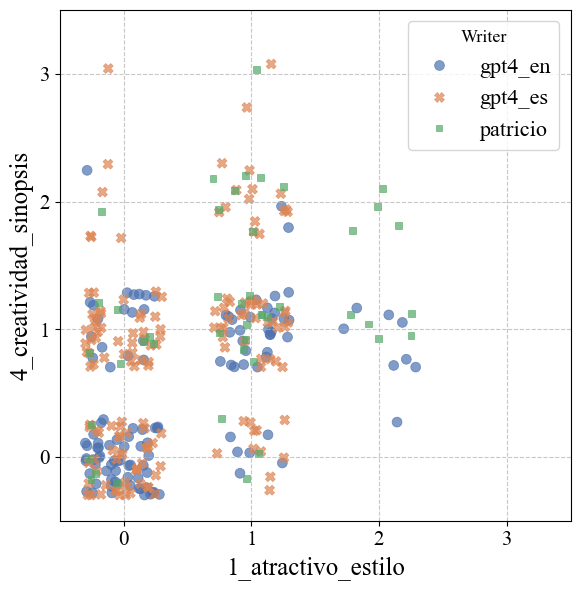

In [ ]:
df_work = df[(df['5_autoria_sinopsis'] == 'Una inteligencia artificial.')]
plot_scatter(df_work, '1_atractivo_estilo', '4_creatividad_sinopsis', 'sinopsis_writer')

## Correlaciones

In [ ]:
columns_corr = ['1_atractivo_estilo_gpt4', '1_atractivo_estilo_patricio',
       '1_atractivo_tema_gpt4', '1_atractivo_tema_patricio',
       '2_originalidad_estilo_gpt4', '2_originalidad_estilo_patricio',
       '2_originalidad_tema_gpt4', '2_originalidad_tema_patricio',
       '4_creatividad_sinopsis_gpt4', '4_creatividad_sinopsis_patricio',]

In [ ]:
df.columns

Index(['timestamp', 'username', '1_atractivo_titulo', '1_atractivo_estilo',
       '1_atractivo_tema', '2_originalidad_titulo', '2_originalidad_estilo',
       '2_originalidad_tema', '3_relevancia', '4_creatividad_titulo',
       '4_creatividad_sinopsis', '4_creatividad_comentario',
       '5_autoria_titulo', '5_autoria_sinopsis', '5_autoria_comentario',
       '6_antologia', '6_opinion_lectores', '6_opinion_criticos',
       '6_voz_propia', '6_comentario', 'title', 'title_id', 'sinopsis_writer',
       'title_writer', 'experiment', 'id_title_sinopsis_writer',
       'id_title_title_writer', 'id_title_user'],
      dtype='object')

In [ ]:
import seaborn as sns

def draw_corr(df):
    # Ajustar el contexto de seaborn para aumentar el tamaño de la fuente
    sns.set_context("notebook", font_scale=1.5)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(df.corr(method='spearman'), cmap='Greens', annot=True, fmt=".2f", annot_kws={"size": 22})
    #plt.title('Matriz de correlación', fontsize=20)
    #plt.xlabel('Variables', fontsize=15)
    #plt.ylabel('Variables', fontsize=15)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.savefig(f'figures/corr.pdf', backend='pgf', bbox_inches='tight', pad_inches=0.1)
    plt.show()

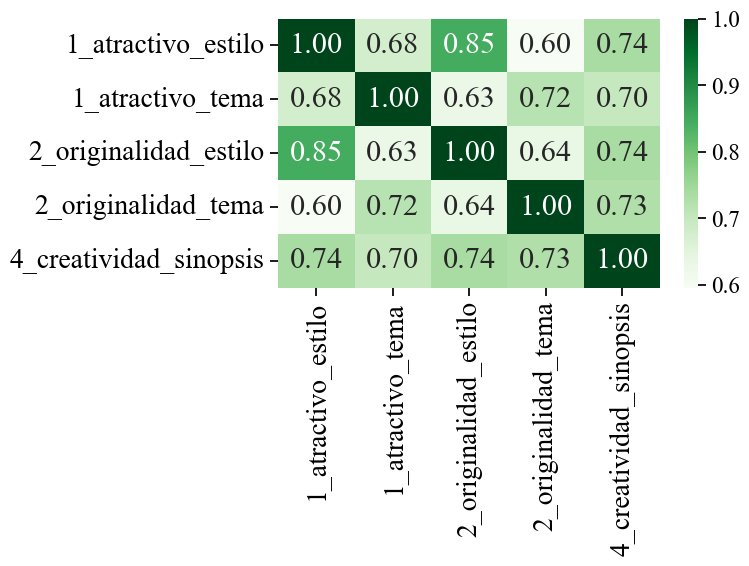

In [ ]:
draw_corr(df[['1_atractivo_estilo',
       '1_atractivo_tema', '2_originalidad_estilo',
       '2_originalidad_tema',
       '4_creatividad_sinopsis',]])

## Análisis de significancia

In [ ]:
from scipy.stats import wilcoxon

In [ ]:
def get_wilcoxon_test(df, left = '_gpt4', rigth = '_patricio'):
    wilcoxon_results = []
    # Iterar sobre las columnas y calcular el test de Wilcoxon para las que tienen el mismo nombre con _gpt4 y _patricio
    for col in columns_corr:
        if col.endswith(left):
            col_patricio = col.replace(left, rigth)
            if col_patricio in df.columns:
                stat, p_value = wilcoxon(df[col].tolist(), df[col_patricio].tolist())
                wilcoxon_results.append({'Variable': col[:-6], 'Estadístico Wilcoxon': stat, 'Valor p': p_value})
    wilcoxon_results_df = pd.DataFrame(wilcoxon_results)
    return wilcoxon_results_df

Significación estadística entre GPT4 y Patricio en español.

In [ ]:
get_wilcoxon_test(dfs_sinopsis['df_patricio_gpt_es'])

,Variable,Estadístico Wilcoxon,Valor p
0,1_atractivo_estil,204.0,7.168928e-26
1,1_atractivo_tem,1610.5,1.363227e-13
2,2_originalidad_estil,116.0,1.733274e-27
3,2_originalidad_tem,1220.0,4.914394e-18
4,4_creatividad_sinopsi,333.0,1.093243e-24


Para validar la rúbrica, tenemos dos grupos de usuarios que han votado de manera distinta las sinopsis de Patricio. Vamos a comprobar si está bien hecha la rúbrica tratando de observar si hay diferencias entre las distribuciones.

In [ ]:
get_wilcoxon_test(dfs_sinopsis['df_patricio_gpt_en'])

,Variable,Estadístico Wilcoxon,Valor p
0,1_atractivo_estil,677.5,2.851710e-18
1,1_atractivo_tem,1213.0,9.152415e-12
2,2_originalidad_estil,598.0,5.050739e-19
3,2_originalidad_tem,804.0,1.318616e-13
4,4_creatividad_sinopsi,1066.5,1.254151e-17
